<a href="https://colab.research.google.com/github/imraunav/Speech-Emotion-Recognition/blob/main/Speech_Emotion_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download files from google drive using terminal commands

In [1]:
!gdown https://drive.google.com/u/0/uc?id=1wWsrN2Ep7x6lWqOXfr4rpKGYrJhWc8z7  # for files
# gdown <file_id>                                 # alternative format
# gdown --folder https://drive.google.com/drive/folders/<file_id>  # for folders
# gdown --folder --id <file_id>

Downloading...
From: https://drive.google.com/u/0/uc?id=1wWsrN2Ep7x6lWqOXfr4rpKGYrJhWc8z7
To: /content/speech-emotion-recognition-ravdess-data.zip
100% 78.1M/78.1M [00:01<00:00, 55.5MB/s]


In [2]:
!unzip speech-emotion-recognition-ravdess-data.zip > op # suppressing the terminal output

In [3]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split

In [10]:
from tqdm import tqdm

In [4]:
def extract_feature(filename, mfcc, chroma, mel):
  with soundfile.SoundFile(filename) as sound_file:
    X = sound_file.read(dtype="float32")
    sample_rate=sound_file.samplerate # sampling rate of the sound file
    if chroma==True:
        stft=np.abs(librosa.stft(X))
    result=np.array([])
    if mfcc==True:
        mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))
    if chroma==True:
        chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result=np.hstack((result, chroma))
    if mel==True:
        mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
        result=np.hstack((result, mel))
  return result

In [5]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

In [6]:
observed_emotions=['calm', 'happy', 'fearful', 'disgust']

In [7]:
class_encode = {
    'calm': [1, 0, 0, 0],
    'happy': [0, 1, 0, 0],
    'fearful': [0, 0, 1, 0],
    'disgust': [0, 0, 0, 1],
}

In [8]:
def load_data(test_size=0.2):
    x,y=[],[]
    for file in tqdm(glob.glob("Actor_*/*.wav")):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(class_encode[emotion])
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [11]:
x_train,x_test,y_train,y_test=load_data(test_size=0.25)


100%|██████████| 1440/1440 [00:40<00:00, 35.26it/s]


In [14]:
import tensorflow as tf

x_train = tf.data.Dataset.from_tensor_slices(x_train)
x_test = tf.data.Dataset.from_tensor_slices(x_test)
y_train = tf.data.Dataset.from_tensor_slices(y_train)
y_test = tf.data.Dataset.from_tensor_slices(y_test)

train_ds = tf.data.Dataset.zip((x_train, y_train))
test_ds = tf.data.Dataset.zip((x_test, y_test))

The model

In [15]:
from tensorflow import keras

In [16]:
def build_FCNN():
  inputs = keras.Input(shape=(180,))
  l1 = keras.layers.Dense(256, activation='tanh')(inputs)
  l2 = keras.layers.Dense(128, activation='tanh')(l1)
  l3 = keras.layers.Dense(4, activation='softmax')(l2)
  return keras.Model(inputs=[inputs], outputs=[l3])



In [29]:
classifier = build_FCNN()
classifier.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180)]             0         
                                                                 
 dense_6 (Dense)             (None, 256)               46336     
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 4)                 516       
                                                                 
Total params: 79748 (311.52 KB)
Trainable params: 79748 (311.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
classifier.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['Accuracy']
)

In [31]:
log = classifier.fit(train_ds.batch(8), shuffle=True, epochs=1000, verbose=0)

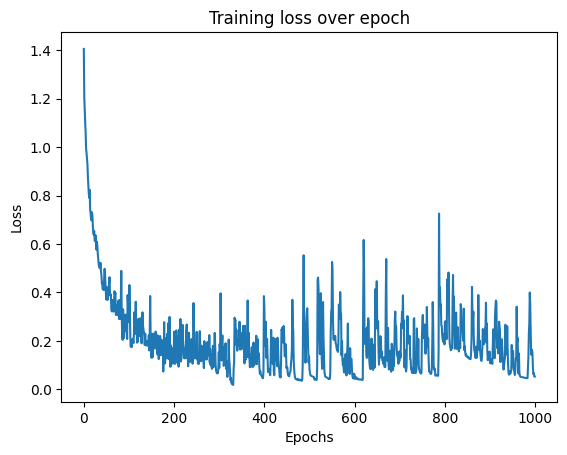

In [32]:
from matplotlib import pyplot as plt

plt.plot(log.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training loss over epoch")
plt.show()

In [33]:
loss, acc = classifier.evaluate(test_ds.batch(1))
print(f"Avg. loss on test data: {loss}")
print(f"Accuracy : {acc}")

192/192 [==============================] - 1s 3ms/step - loss: 1.8466 - Accuracy: 0.6510
Avg. loss on test data: 1.846591830253601
Accuracy : 0.6510416865348816
